
# FACTR Knowledge Base Inspector

This notebook inspects the **FACTR** knowledge base artefacts built on **18 Nov 2025**.

It assumes the following files exist **relative to the project root**:

- `data/processed/KB_passages.jsonl`
- `data/processed/KB_embeddings.npy`
- `data/processed/KB_embeddings.meta.json`
- `data/processed/KB_all.faiss`
- `data/processed/KB_all.map.jsonl`
- `data/processed/KB_islam.faiss`
- `data/processed/KB_islam.map.jsonl`
- `data/processed/KB_christian.faiss`
- `data/processed/KB_christian.map.jsonl`
- `data/processed/LAST_KB.json`

You can adapt the paths in the configuration cell below if needed.


In [1]:

from pathlib import Path
import json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
PROJECT_ROOT = Path.cwd()  # run this notebook from the project root
KB_PASSAGES_PATH = PROJECT_ROOT / "data" / "processed" / "KB_passages.jsonl"
KB_EMB_PATH = PROJECT_ROOT / "data" / "processed" / "KB_embeddings.npy"
KB_EMB_META_PATH = PROJECT_ROOT / "data" / "processed" / "KB_embeddings.meta.json"
LAST_KB_PATH = PROJECT_ROOT / "data" / "processed" / "LAST_KB.json"

KB_PASSAGES_PATH, KB_EMB_PATH, KB_EMB_META_PATH, LAST_KB_PATH


(WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/data/processed/KB_passages.jsonl'),
 WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/data/processed/KB_embeddings.npy'),
 WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/data/processed/KB_embeddings.meta.json'),
 WindowsPath('c:/Users/lukmaan/Msc_in_AI/FATCR/data/processed/LAST_KB.json'))

## 1. Embedding metadata and manifest

In [2]:

# Load embedding metadata
emb_meta = json.loads(KB_EMB_META_PATH.read_text(encoding="utf-8"))
emb = np.load(KB_EMB_PATH, mmap_mode="r")
rows, dim = emb.shape

print("Embedding file:", KB_EMB_PATH)
print("Shape:", emb.shape, "(rows, dim)")
print("Dtype:", emb.dtype)
print("\nEmbedding meta.json:")
for k, v in emb_meta.items():
    print(f"  {k}: {v}")

# Load LAST_KB manifest if present
if LAST_KB_PATH.exists():
    last_kb = json.loads(LAST_KB_PATH.read_text(encoding="utf-8"))
    print("\nLAST_KB.json:")
    for k, v in last_kb.items():
        if k != "artefacts":
            print(f"  {k}: {v}")
    print("\nArtefacts:")
    for name, artefact in last_kb.get("artefacts", {}).items():
        print(f"  {name}: {artefact}")
else:
    last_kb = None
    print("\n[WARN] LAST_KB.json not found.")


Embedding file: c:\Users\lukmaan\Msc_in_AI\FATCR\data\processed\KB_embeddings.npy
Shape: (162712, 384) (rows, dim)
Dtype: float32

Embedding meta.json:
  model_name: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
  count: 162712
  dim: 384
  normalized: True

LAST_KB.json:
  time: 2025-11-18T12:18:54.419827Z
  dim: 384
  normalized: True
  model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

Artefacts:
  all: {'faiss': 'data/processed/KB_all.faiss', 'map': 'data/processed/KB_all.map.jsonl'}
  islam: {'faiss': 'data/processed/KB_islam.faiss', 'map': 'data/processed/KB_islam.map.jsonl'}
  christian: {'faiss': 'data/processed/KB_christian.faiss', 'map': 'data/processed/KB_christian.map.jsonl'}
  passages: data/processed/KB_passages.jsonl


## 2. Sample of passages

In [3]:

# Load a subset of KB_passages.jsonl for inspection
SAMPLE_ROWS = 5000  # adjust if you want more/fewer

records = []
with KB_PASSAGES_PATH.open("r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= SAMPLE_ROWS:
            break
        rec = json.loads(line)
        records.append(rec)

df_sample = pd.DataFrame(records)
df_sample.head()


,tradition,genre,collection,source,lang,book,chapter,verse,text,ref,number,grade,group_key,source_name,source_collection,source_file
0,Islam,scripture,Quran,Quran (EN: semarketir/quranjson),en,Al-Fatiha,1,1,"In the name of God, the Gracious, the Merciful.",Qur'an 1:1,None,None,quran-1-1,quran_en,Quran,data/raw/kb/_normalized/quran_en.jsonl
1,Islam,scripture,Quran,Quran (EN: semarketir/quranjson),en,Al-Fatiha,1,2,"Praise be to God, Lord of the Worlds.",Qur'an 1:2,None,None,quran-1-2,quran_en,Quran,data/raw/kb/_normalized/quran_en.jsonl
2,Islam,scripture,Quran,Quran (EN: semarketir/quranjson),en,Al-Fatiha,1,3,"The Most Gracious, the Most Merciful.",Qur'an 1:3,None,None,quran-1-3,quran_en,Quran,data/raw/kb/_normalized/quran_en.jsonl
3,Islam,scripture,Quran,Quran (EN: semarketir/quranjson),en,Al-Fatiha,1,4,Master of the Day of Judgment.,Qur'an 1:4,None,None,quran-1-4,quran_en,Quran,data/raw/kb/_normalized/quran_en.jsonl
4,Islam,scripture,Quran,Quran (EN: semarketir/quranjson),en,Al-Fatiha,1,5,"It is You we worship, and upon You we call for...",Qur'an 1:5,None,None,quran-1-5,quran_en,Quran,data/raw/kb/_normalized/quran_en.jsonl


## 3. KB composition (tradition, genre, language, collection)

In [4]:

def counter_series(counter: Counter, top_n: int | None = None) -> pd.Series:
    items = counter.most_common(top_n)
    if not items:
        return pd.Series(dtype="int64")
    labels, counts = zip(*items)
    return pd.Series(counts, index=labels)

traditions = Counter(df_sample.get("tradition").fillna("Unknown"))
genres = Counter(df_sample.get("genre").fillna("Unknown"))
langs = Counter(df_sample.get("lang").fillna("Unknown"))
collections = Counter(df_sample.get("collection").fillna("Unknown"))

print("Total sampled passages:", len(df_sample))

print("\nBy tradition:")
display(counter_series(traditions))

print("\nBy genre:")
display(counter_series(genres))

print("\nBy language:")
display(counter_series(langs))

print("\nTop 20 collections:")
display(counter_series(collections, top_n=20))


Total sampled passages: 5000

By tradition:


Islam    5000
dtype: int64


By genre:


scripture    5000
dtype: int64


By language:


en    5000
dtype: int64


Top 20 collections:


Quran    5000
dtype: int64

## 4. Visual summaries for the dissertation

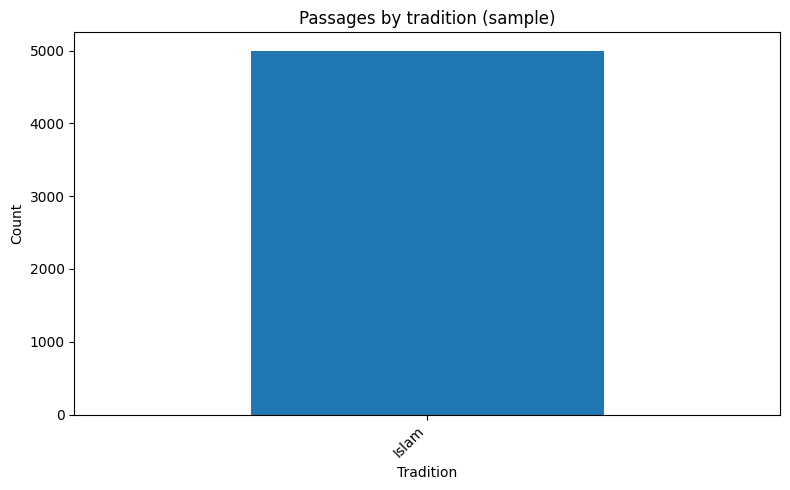

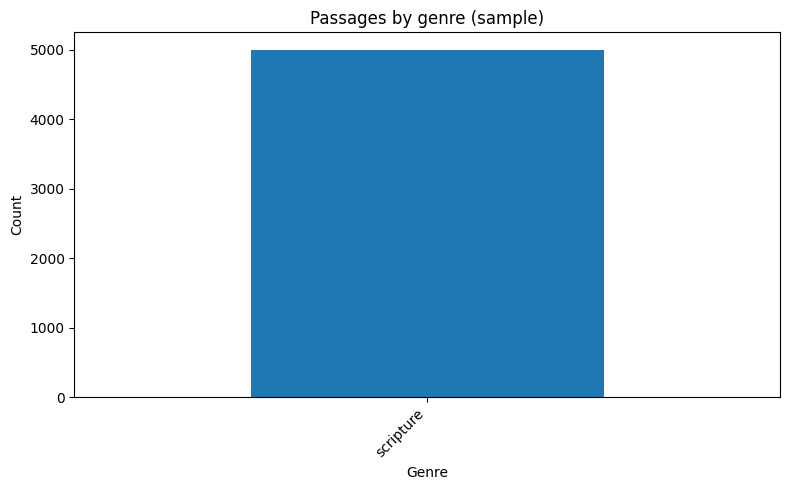

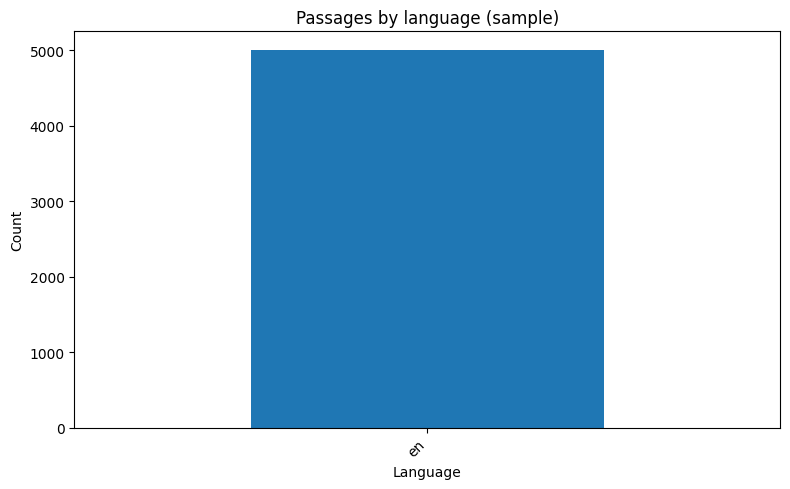

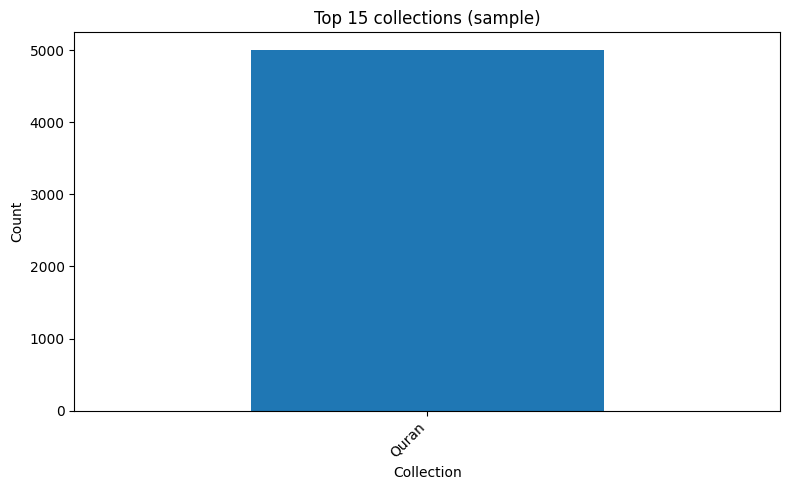

In [5]:

# Helper to draw a simple bar chart (no seaborn, no custom colours)
def plot_bar(series: pd.Series, title: str, xlabel: str, ylabel: str, rotation: int = 45):
    plt.figure(figsize=(8, 5))
    series.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation, ha="right")
    plt.tight_layout()
    plt.show()

# 4.1 Passages by tradition
plot_bar(counter_series(traditions), "Passages by tradition (sample)", "Tradition", "Count")

# 4.2 Passages by genre
plot_bar(counter_series(genres), "Passages by genre (sample)", "Genre", "Count")

# 4.3 Languages
plot_bar(counter_series(langs), "Passages by language (sample)", "Language", "Count")

# 4.4 Top 15 collections
plot_bar(counter_series(collections, top_n=15), "Top 15 collections (sample)", "Collection", "Count")


## 5. Hadith / Tafsir / Commentary coverage

Bucket counts (sample):


other    5000
dtype: int64

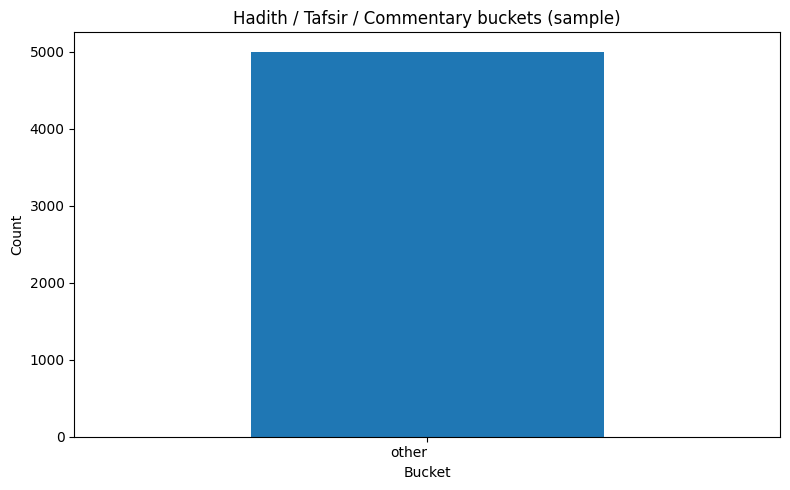

In [6]:

bucket_counts = Counter()

def bucket_row(rec: dict) -> str:
    genre = (rec.get("genre") or "").lower()
    coll = (rec.get("collection") or "").lower()

    if "hadith" in genre or "hadith" in coll:
        return "hadith"
    if "tafsir" in genre or "tafsīr" in genre or "tafsir" in coll or "tafsīr" in coll:
        return "tafsir"
    if "commentary" in genre or "commentary" in coll:
        return "commentary"
    return "other"

for rec in records:
    b = bucket_row(rec)
    bucket_counts[b] += 1

def counter_series(counter: Counter, top_n: int | None = None) -> pd.Series:
    items = counter.most_common(top_n)
    if not items:
        return pd.Series(dtype="int64")
    labels, counts = zip(*items)
    return pd.Series(counts, index=labels)

bucket_series = counter_series(bucket_counts)
print("Bucket counts (sample):")
display(bucket_series)

plot_bar(bucket_series, "Hadith / Tafsir / Commentary buckets (sample)", "Bucket", "Count", rotation=0)


### 5.1 Example passages per bucket

In [7]:

examples = {"hadith": [], "tafsir": [], "commentary": [], "other": []}

for rec in records:
    b = bucket_row(rec)
    if len(examples[b]) >= 3:
        continue
    text = rec.get("text") or rec.get("passage") or ""
    if not text:
        continue
    examples[b].append({
        "collection": rec.get("collection"),
        "genre": rec.get("genre"),
        "tradition": rec.get("tradition"),
        "text": text[:400].replace("\n", " "),
    })
    if all(len(v) >= 3 for v in examples.values()):
        break

for bucket, rows in examples.items():
    print(f"\n=== {bucket.upper()} EXAMPLES ({len(rows)}) ===")
    for i, rec in enumerate(rows, start=1):
        print(f"\n[{bucket} #{i}]")
        print("collection:", rec["collection"])
        print("genre     :", rec["genre"])
        print("tradition :", rec["tradition"])
        print("text      :", rec["text"])



=== HADITH EXAMPLES (0) ===

=== TAFSIR EXAMPLES (0) ===

=== COMMENTARY EXAMPLES (0) ===

=== OTHER EXAMPLES (3) ===

[other #1]
collection: Quran
genre     : scripture
tradition : Islam
text      : In the name of God, the Gracious, the Merciful.

[other #2]
collection: Quran
genre     : scripture
tradition : Islam
text      : Praise be to God, Lord of the Worlds.

[other #3]
collection: Quran
genre     : scripture
tradition : Islam
text      : The Most Gracious, the Most Merciful.


## 6. Export summary tables for the dissertation

In [8]:

OUT_DIR = PROJECT_ROOT / "data" / "kb_inspect_exports"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def to_df(counter: Counter, top_n: int | None = None) -> pd.DataFrame:
    items = counter.most_common(top_n)
    if not items:
        return pd.DataFrame(columns=["label", "count"])
    labels, counts = zip(*items)
    return pd.DataFrame({"label": labels, "count": counts})

to_df(traditions).to_csv(OUT_DIR / "kb_by_tradition.csv", index=False)
to_df(genres).to_csv(OUT_DIR / "kb_by_genre.csv", index=False)
to_df(langs).to_csv(OUT_DIR / "kb_by_language.csv", index=False)
to_df(collections, top_n=50).to_csv(OUT_DIR / "kb_top_collections.csv", index=False)

print("Exported:")
for p in OUT_DIR.glob("*.csv"):
    print(" -", p)


Exported:
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports\kb_by_genre.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports\kb_by_language.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports\kb_by_tradition.csv
 - c:\Users\lukmaan\Msc_in_AI\FATCR\data\kb_inspect_exports\kb_top_collections.csv
